In [48]:
#importing the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set(style='whitegrid')


In [49]:
#import the dataset
df = pd.read_csv("/Users/masondelan/Downloads/data/Occupancy_Estimation.csv")
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


# **DATA CLEANING AND PREPROCESSING**

# Missing values and duplicates

In [50]:
#Check for missing values in data
missing=df.isna().sum()
print(missing[misssing>0] if missing.sum()>0 else "No missing values found")

No missing values found


There is no missing values in the dataset

In [51]:
#Check for duplicate values
dup_count=df.duplicated().sum()
print(dup_count)

0


The number of duplicate rows is zero so the data is clean in that respect.

# Outliers/Anomaly detection

In [52]:
#define function to detect outliers
def detect_outliers_iqr(df, cols):
    outlier_summary = []

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        outlier_summary.append([col, outliers, lower, upper])

    return pd.DataFrame(outlier_summary,columns=["Feature", "Outlier_Count", "Lower_Bound", "Upper_Bound"])


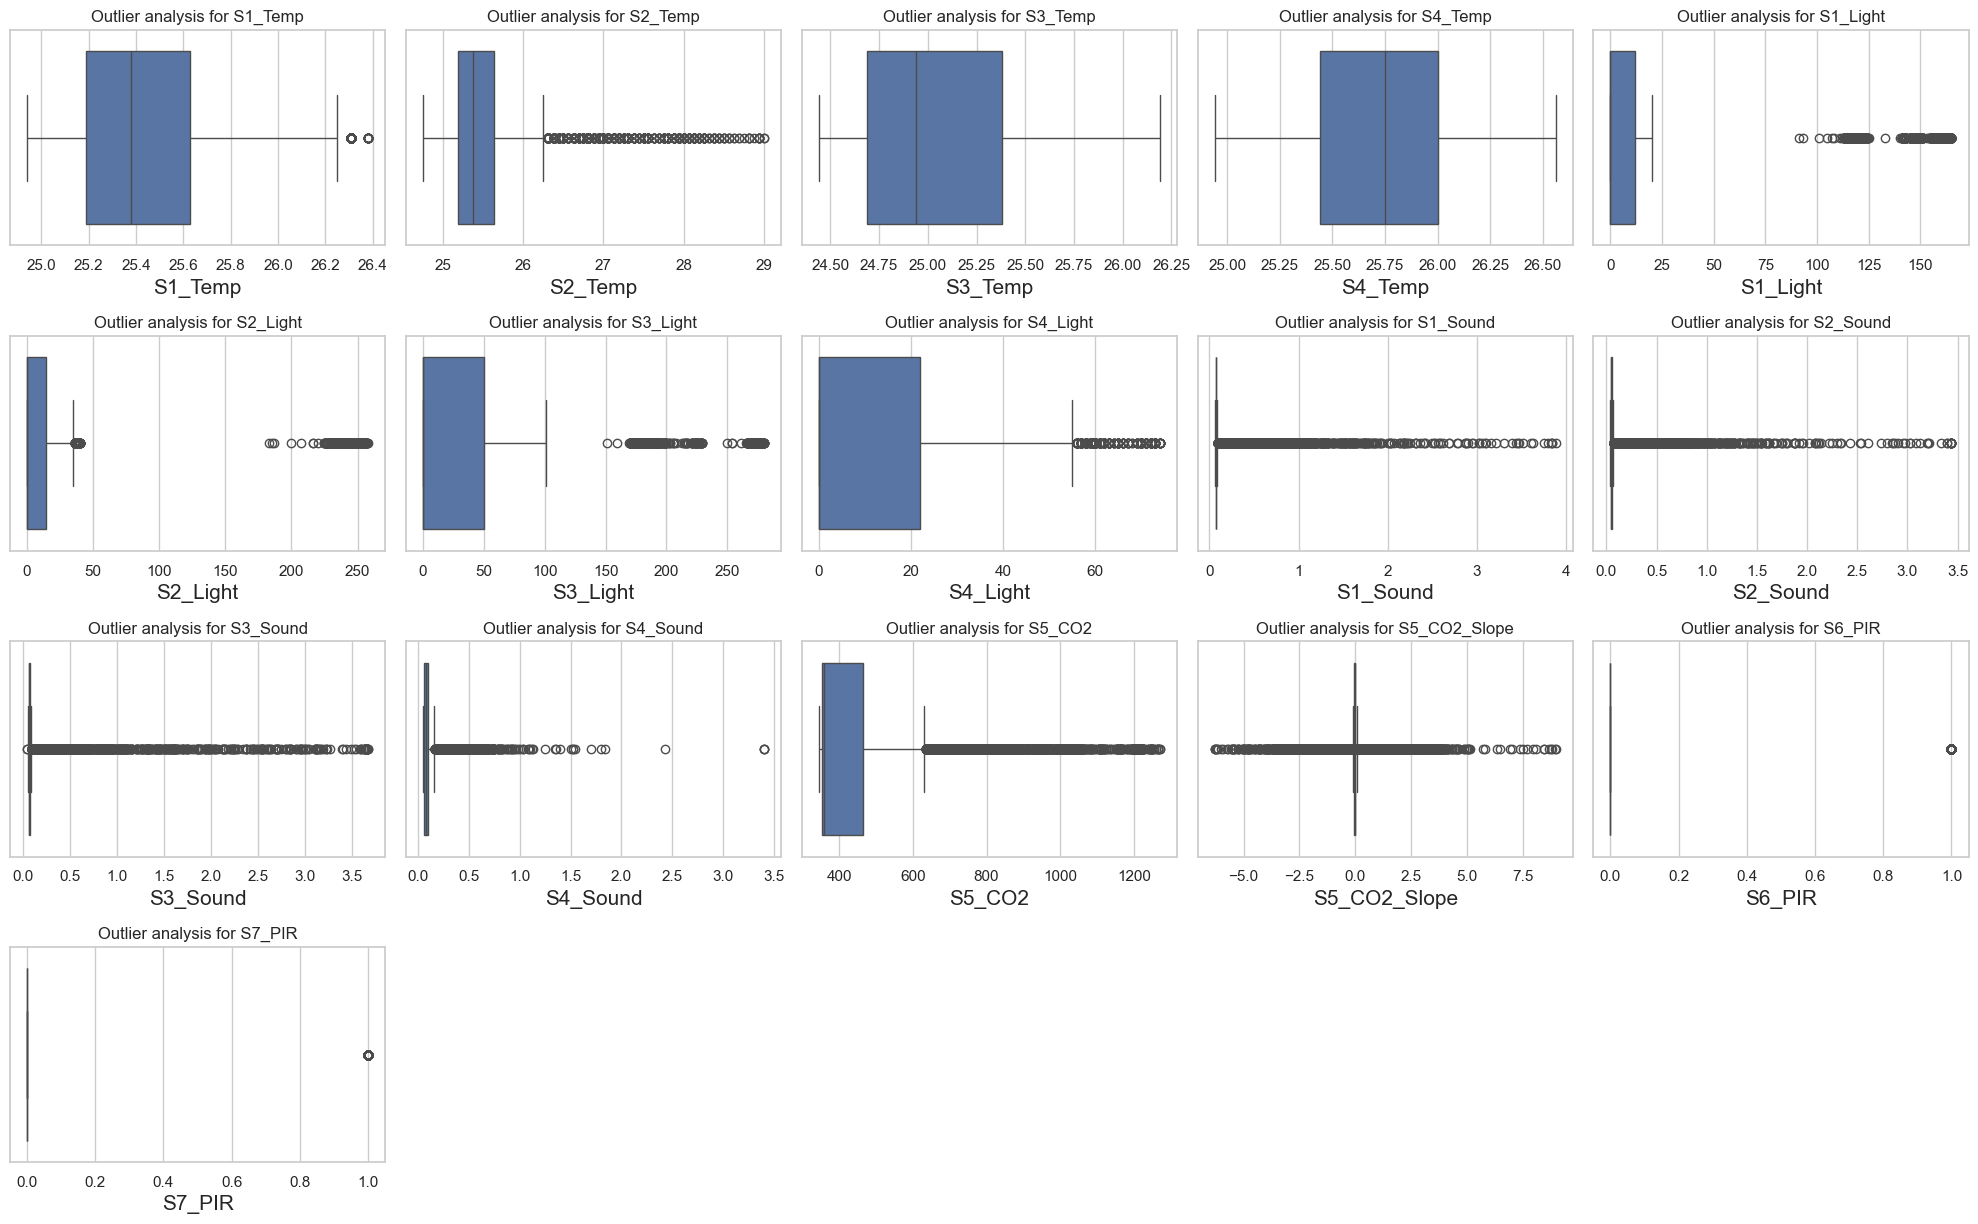

In [53]:
#select numeric coloumn
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
#avoid treating room occupancy as outlier
numeric_cols.remove("Room_Occupancy_Count")

plt.figure(figsize = (20, 18))

for i,col in enumerate(numeric_cols,1):
        ax = plt.subplot(6, 5,i)
        sns.boxplot(x=df[col])
        plt.xlabel(col, fontsize = 15)
        plt.title(f'Outlier analysis for {col}')
plt.tight_layout()
plt.show()

In [54]:
#view outliers
outlier_table = detect_outliers_iqr(df, numeric_cols)
outlier_table

,Feature,Outlier_Count,Lower_Bound,Upper_Bound
0,S1_Temp,162,2.453000e+01,26.290000
1,S2_Temp,948,2.453000e+01,26.290000
2,S3_Temp,0,2.365500e+01,26.415000
3,S4_Temp,0,2.460000e+01,26.840000
4,S1_Light,1716,-1.800000e+01,30.000000
5,S2_Light,1017,-2.100000e+01,35.000000
6,S3_Light,950,-7.500000e+01,125.000000
7,S4_Light,543,-3.300000e+01,55.000000
8,S1_Sound,1772,5.500000e-02,0.095000
9,S2_Sound,1703,3.500000e-02,0.075000


The outlier table shows that temperature sensors are mostly stable, with S3 and S4 showing no outliers, while S1 and S2 show moderate deviations. The light and sound sensors have a large number of outliers, which is expected because lighting and noise levels can change suddenly in real environments. The CO2 sensor also shows many outliers due to strong fluctuations in air quality when people enter or leave the room, and the CO2 slope has even more variability as it captures rapid changes. The PIR motion sensors show many outliers because their data is sparse and mostly zeros, making the IQR method unsuitable for binary signals. Overall, light, sound, and CO2 features are the most variable, while temperature remains the most stable.

Outliers are usually treated as errors, noise, or measurement faults that need to be removed or corrected. However, in IoT-based room occupancy sensing, outliers represent meaningful real-world insights. Sudden jumps in light intensity from low value to 120-150 occur when someone switches the lights on. Sharp spikes in sound levels show human activity like movement, footsteps, or conversation. Similarly, sudden increases in CO2 concentration indicate that multiple people have entered the room, and a spike of PIR activity shows direct human motion. These extreme values carry important information that indicates occupancy and not random noise. Therefore, removing such spikes or capping them using outlier treatment would eliminate the signals that help the model detect human presence. Instead of treating these as noise, they should be preserved because they enhance model accuracy and represent important insights into occupancy patterns. We will be doing outlier treatment only for negative values in light sound and CO2, as negative values do not exist.

**OUTLIER TREATMENT**

In [55]:
#From table we can see negative values for the light and Co2 so we lowerit to zeros
light_cols = ['S1_Light','S2_Light','S3_Light','S4_Light']
# Light cannot be negative
df[light_cols] = df[light_cols].where(df[light_cols] >= 0, 0)
#Verify change
print(df[light_cols].min())

S1_Light    0
S2_Light    0
S3_Light    0
S4_Light    0
dtype: int64


In [56]:
#Similarly Co2 slope can not be negative,so we lower to zero
df['S5_CO2_Slope']= df['S5_CO2_Slope'].where(df['S5_CO2_Slope'] >= 0, 0)
print(df['S5_CO2_Slope'].min())

0.0


In [57]:
#Similarly sound can not be negative,so we lower to zero
df['S5_CO2_Slope']= df['S5_CO2_Slope'].where(df['S5_CO2_Slope'] >= 0, 0)
print(df['S5_CO2_Slope'].min())

0.0


In [58]:
#Similarly sound can not have negative value so we lower to 0
df['S4_Sound'] = df['S4_Sound'].where(df['S4_Sound'] >= 0, 0)
print(df['S4_Sound'].min())

0.05


# **Feature Engineering**

This is an important step in our data mining goal.Here we will be creating new features  and transforming existing features so our model can perform well.

Here we will transform and aggregate IoT sensor data like temperature, humidity, CO2, light, motion and construct meaningful features that can detect patterns associated with occupied or  unoccupied rooms.

# Aggregation of sensor features across multiple IoT inputs

Here we will aggregate or combine multiple related sensor readings like the temperature,light,motion into a single meaningful summary.

**Temperature**

Mean temperature across 4 sensors S1,S2,S3,S4 is aggregated into temp_mean.Similarly Standard deviation across sensors is combined with the temp std.

In [59]:
#average of S1_temp,S2_temp,S3_temp,S4_temp
df['Temp_mean'] = df[['S1_Temp','S2_Temp','S3_Temp','S4_Temp']].mean(axis=1)
#standard deviation across temperature sensors
df['Temp_std'] = df[['S1_Temp','S2_Temp','S3_Temp','S4_Temp']].std(axis=1)

The temperature readings from multiple sensors (S1–S4) were combined into aggregate features Temp_mean and Temp_standard deviation. The mean temperature provides an overall room’s thermal condition.The standard deviation captures fluctuations across sensors, which may indicate activity or heat generated by occupants. 

Aggregated temperature features help the model detect patterns associated with room occupancy, such as increased temperatures when people are present.

This helps in dimensionality reduction where instead of 4 separate temperature sensors to the model ,we summarise into a meaningful one feature.

**Light**

In [60]:
#Similarly we summarise light into a single feature instead of 4 separate light features(s1light-s4_light)
df['Light_mean'] = df[['S1_Light','S2_Light','S3_Light','S4_Light']].mean(axis=1)
#Captures variation
df['Light_std'] = df[['S1_Light','S2_Light','S3_Light','S4_Light']].std(axis=1)

Light readings are combined across all four sensors to find Light_mean, and light_standard deviation. The average light intensity shows the overall brightness of the room, while variations in light may signal occupancy changes, such as lights being switched on or off. This aggregation reduces noise and simplifies the feature while retaining important information about lighting patterns.

These aggregated light features are useful in detecting human presence, as occupied rooms show higher or more light readings compared to empty rooms.

**Sound**

In [61]:
df['Sound_mean'] = df[['S1_Sound','S2_Sound','S3_Sound','S4_Sound']].mean(axis=1)
df['Sound_std'] = df[['S1_Sound','S2_Sound','S3_Sound','S4_Sound']].std(axis=1)

Sound sensor readings are aggregated using mean and standard deviation to capture overall noise levels. The variation helps identify sounds created by human presence. These aggregated sound features are indicators of occupancy, as empty rooms generally have lower and more consistent noise readings.

**PIR motion**

In [62]:
df['PIR_sum'] = df[['S6_PIR','S7_PIR']].sum(axis=1)

The PIR sensors detect motion within specific zones. Since the two PIR sensors monitor overlapping areas, their readings are summed to create a single motion activity measure. A higher sum indicates more frequent movement inside the room, which is strongly linked to human presence. These aggregated motion features indicate occupancy, as the presence of people directly triggers the PIR sensors.



# **Feature Construction**

#### **BINARY OCCUPANCY FEATURE**

In [63]:
#lets analyse our target variable
df['Room_Occupancy_Count'].value_counts()

Room_Occupancy_Count
0    8228
2     748
3     694
1     459
Name: count, dtype: int64

We can see majority of room is unoccupied with 8228 count. Only few rooms are occupied with 1 person(459),2 person(748) and 3 person(694). So we can combine the occupied room and create a binary feature.

In [64]:
# Convert to binary occupancy where 0=Not Occupied and 1=Occupied
df['occupancy_binary']=df['Room_Occupancy_Count'].apply(lambda x:0 if x==0 else 1)
df['occupancy_binary'].value_counts()

occupancy_binary
0    8228
1    1901
Name: count, dtype: int64

The occupancy binary feature indicates whether the room is occupied or not.The majority of observations are not occupied and a small portion is occupied, showing an imbalance.

This is our target feature for our classification problem.

#### **COMBINED SENSOR METRICS FOR MOTION,SOUND AND LIGHT**

Feature is derived by combining readings from multiple sensors to capture patterns that we can not get from single sensors.These additional features enhances the predictive power of our dataset.

In [65]:
#product of motion and light to capture activity
df['Motion_Light'] = df['PIR_sum'] * df['Light_mean']


The above features created multiple motions by light intensity, capturing motion or activity in well-lit conditions (illuminated), which indicates occupancy. A higher value will indicate a strong presence. This feature is also helpful in differentiating between random PIR triggers and real activity.

In [66]:
#product of light and sound to indicate human presence
df['Sound_Light'] = df['Sound_mean'] * df['Light_mean']

 Similarly, Sound * Light shows the co-occurrence of noise and brightness, highlighting human presence in the room. When both signals are high,it shows active usage of room. This feature helps to separate true human generated sound from background noise that can happen when the room is empty.
 


# **Feature Extraction and Discretization**

#### **Time based Feature extraction and binning**

This feature helps identify which hour of the day rooms are more likely to be occupied. It is constructed by combining Date and Time columns.

In [67]:
#convert date and time column to strings
df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)

#combine data+time columns
df['datetime'] = pd.to_datetime(df['Date'] + ' '+ df['Time'],errors='coerce')

#extract hour
df['hour'] = df['datetime'].dt.hour

After extracting hour column, we group hours into time-of-day bins. These bins make it easier to analyze occupancy patterns during different parts of the day and allow clearer interpretation of daily occupancy trends during EDA.

In [68]:
#converting hours into bins and creating Time-of-Day Categories
df["hour_bin"] = pd.cut(df["hour"],bins=[0, 6, 12, 18, 24],labels=["night", "morning", "afternoon", "evening"],right=False)
df["hour_bin"].value_counts()

hour_bin
night        2784
evening      2772
afternoon    2333
morning      2240
Name: count, dtype: int64



# **Removing columns not relevent for analysis**

Here we will remove columns not relevant for our analysis

In [69]:
#we have already extracted hour_bin so we delete data,time
df = df.drop(columns=['Date', 'Time'])

In [70]:
#final columns
print(df.columns.tolist())

['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count', 'Temp_mean', 'Temp_std', 'Light_mean', 'Light_std', 'Sound_mean', 'Sound_std', 'PIR_sum', 'occupancy_binary', 'Motion_Light', 'Sound_Light', 'datetime', 'hour', 'hour_bin']


We will be only using above relevant column for EDA, including sensors, aggregated features, engineered features, and time features. This way we can derive meaningful insights from EDA.





# **EXPLORATORY DATA ANALYSIS**

EDA will be performed to understand sensor behavior and identify the most predictive signals for occupancy classification.

## **Occupancy Distribution and Class Imbalance**

### **What is the overall Occupancy distribution?**

occupancy_binary
0    81.232106
1    18.767894
Name: proportion, dtype: float64


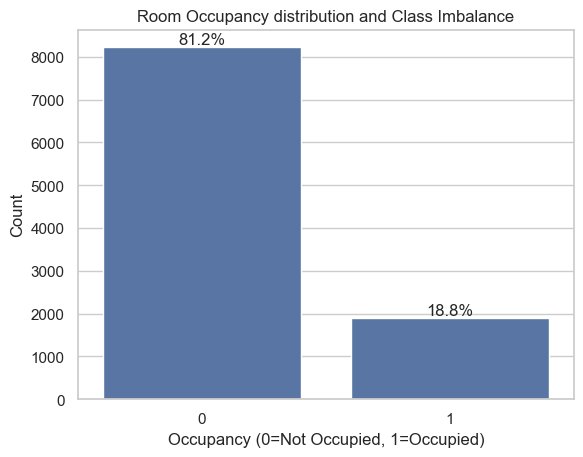

In [71]:
#Calculate count from binary occupancy column
count=df[['occupancy_binary']].value_counts()
#percentage 
percentage = df['occupancy_binary'].value_counts(normalize=True) * 100
print(percentage)

#Plot bar chart with percentages
ax=sns.countplot(x='occupancy_binary', data=df)

#to add percentages on top of bars
#Total samples
total = df.shape[0]
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

#labels axis
plt.title('Room Occupancy distribution and Class Imbalance')
plt.xlabel('Occupancy (0=Not Occupied, 1=Occupied)')
plt.ylabel('Count')
plt.show()

The dataset has a class imbalance in the occupancy_binary variable, with 81.2% of the observations corresponding to unoccupied rooms (0) and only 18.8% corresponding to occupied rooms (1). This imbalance is important to consider as it can directly impact our model performance.We can address this by using techniques like undersampling the majoruty class and using metrics like precision, recall, and F1-score rather than overall accuracy. By addressing the 18.8% minority class, the models can provide reliable and accurate predictions of room occupancy.

### **How does occupancy vary across hours of the day and week?**

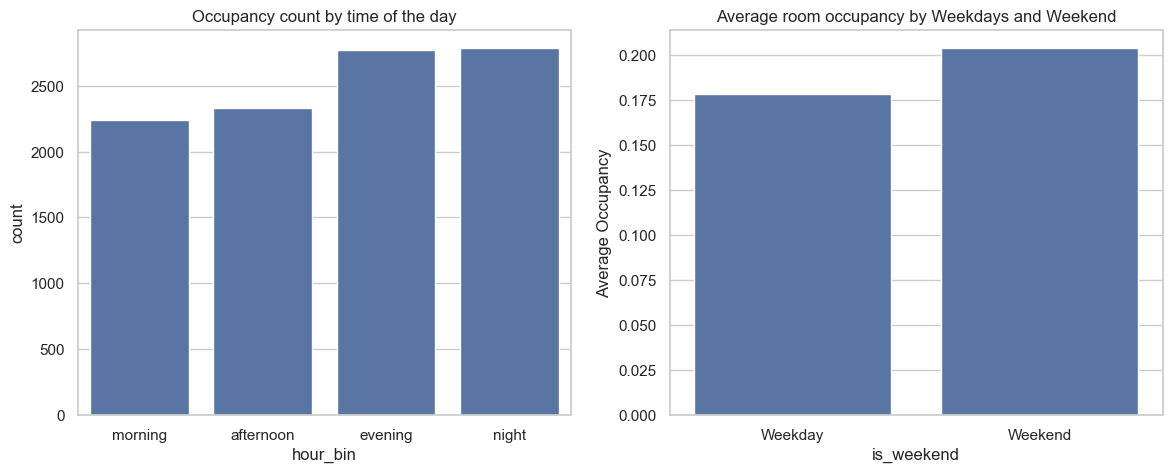

In [72]:
#mean occupancy by hour
occ_by_hour = df.groupby("hour")["occupancy_binary"].mean()
#create weekend from datatime
df["is_weekend"] = df["datetime"].dt.dayofweek >= 5
#Compute mean occupancy by weekend and weekday
occ_by_weekend = df.groupby("is_weekend")["occupancy_binary"].mean().reset_index()

#side by side plot
fig,axes = plt.subplots(1, 2, figsize=(14,5))

#plot occupany in a day and week
#Occupancy plot count by hour_bin
sns.countplot(x="hour_bin", data=df, order=["morning","afternoon","evening","night"],ax=axes[0])
axes[0].set_title("Occupancy count by time of the day")
#plot avg occupancy in weekend
sns.barplot(x="is_weekend", y="occupancy_binary", data=occ_by_weekend, ax=axes[1])
axes[1].set_xticks([0,1])
axes[1].set_xticklabels(["Weekday", "Weekend"])
axes[1].set_title("Average room occupancy by Weekdays and Weekend")
axes[1].set_ylabel("Average Occupancy")
plt.show()

On analysing room occupancy across different times of day ,we can see that occupancy is highest during the night(2,784 counts) and evening(2,772 counts),followed by afternoon(2,333 counts) and mornings(2,240 counts). When examining occupancy patterns by day type, the mean occupancy proportion is slightly higher on weekends (20.35%) compared to weekdays (17.80%).The room is used all day, but there are times when it is busier, and occupancy is slightly higher on weekends.Such insights can help building managers optimize staffing, lighting, and HVAC operations based on actual occupancy patterns.

# Evaluating Individual Sensor Effectiveness for Detecting Occupancy

### **How well do individual sensors(temperature, light, sound, CO₂, PIR) distinguish occupied vs unoccupied conditions?**

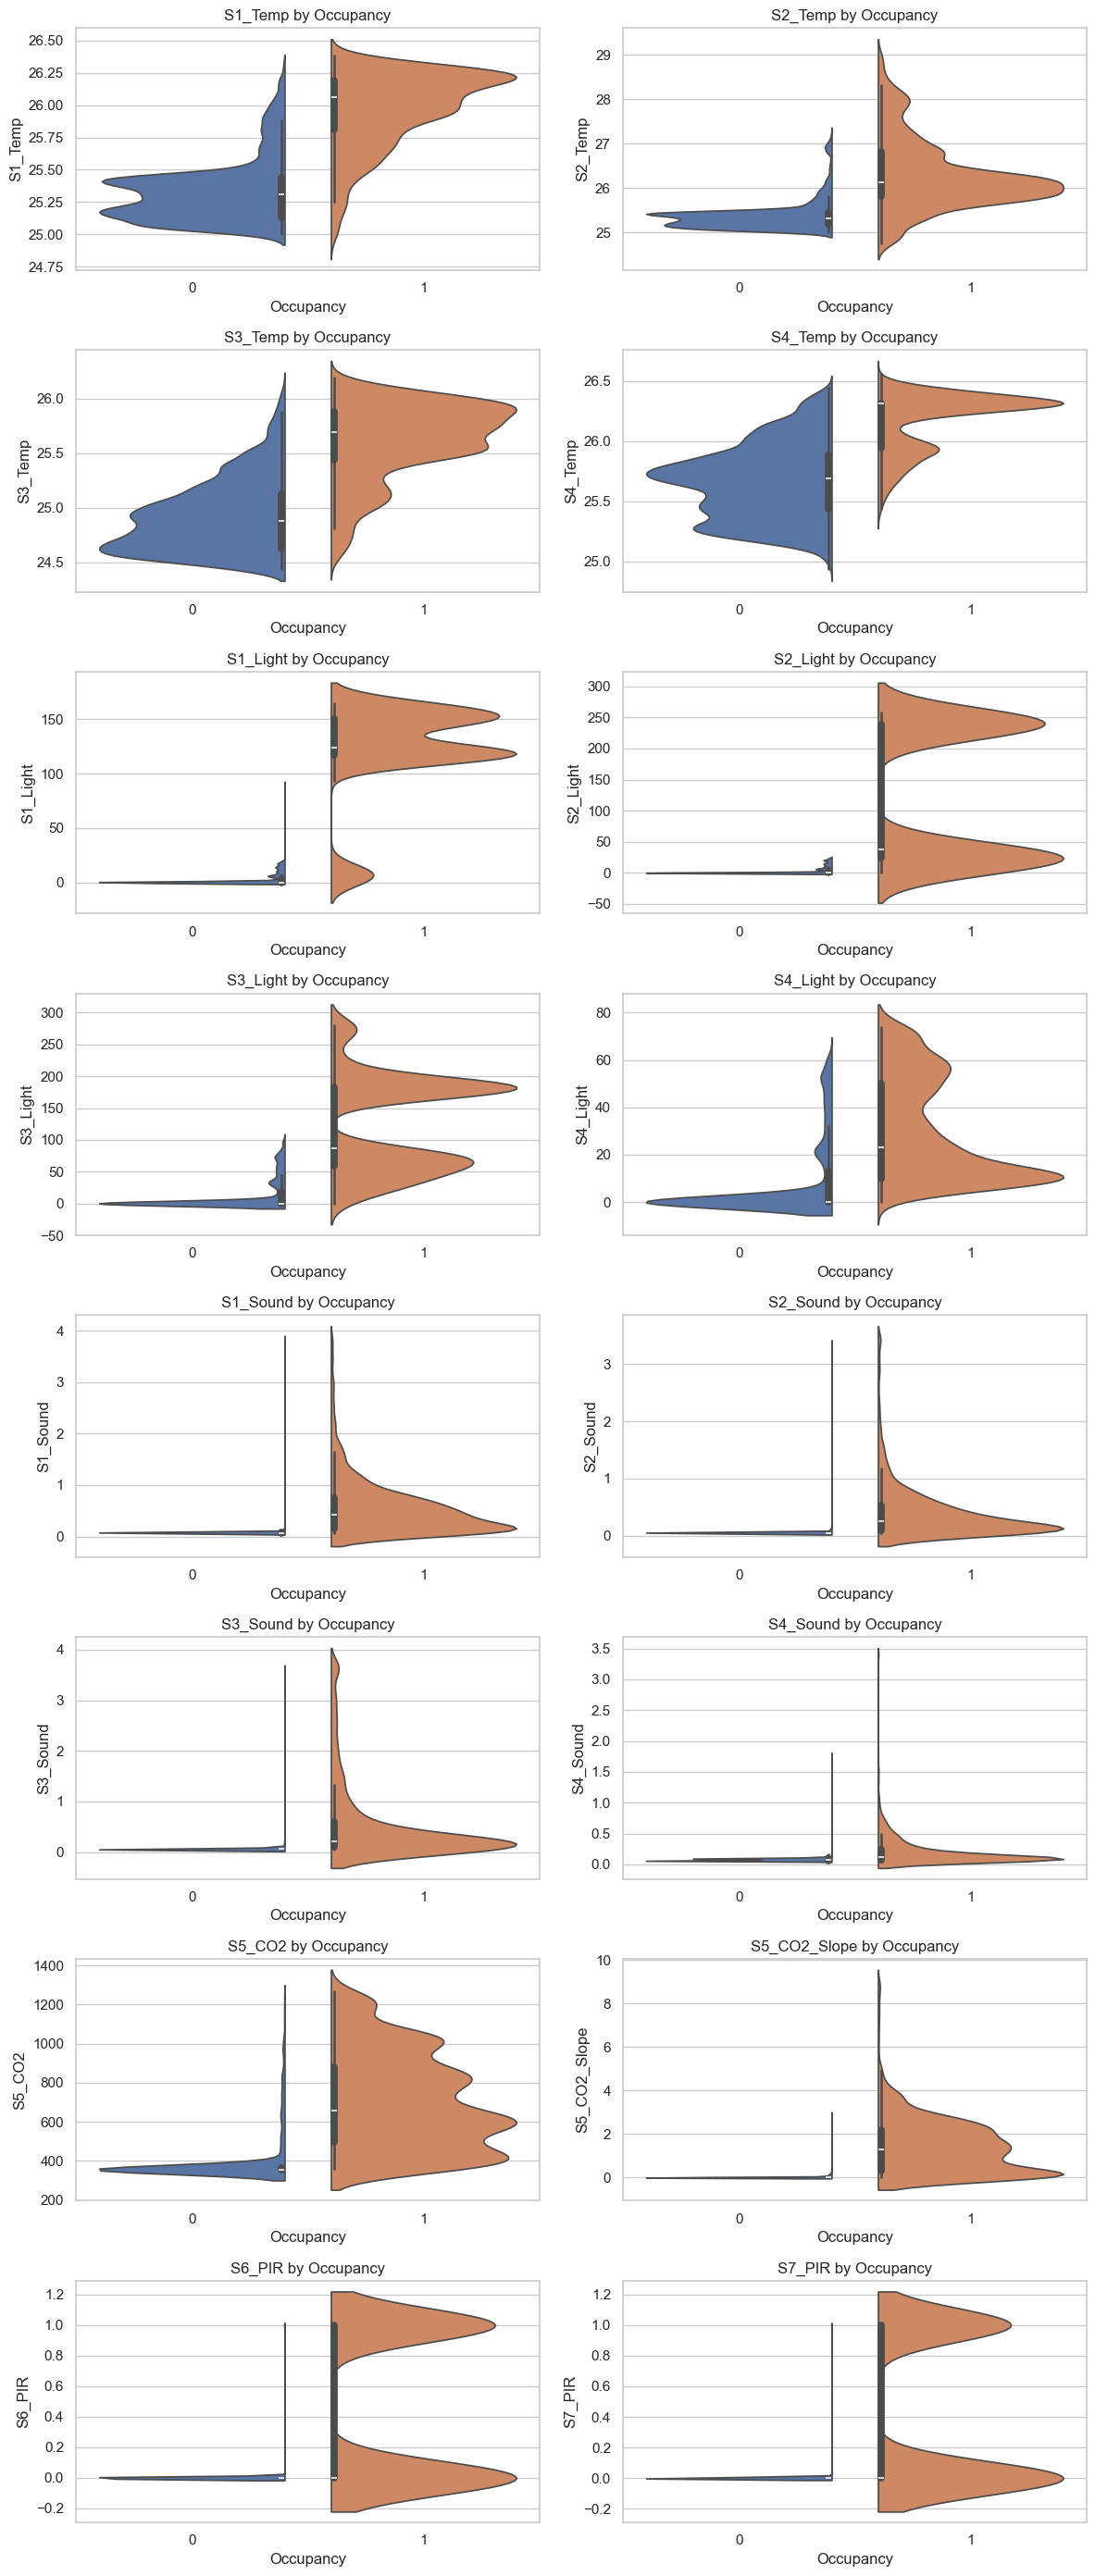

In [73]:
#select all induvidual sensor columns
sensor_cols = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp','S1_Light', 'S2_Light', 'S3_Light', 'S4_Light',
               'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound','S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']
fig, axes = plt.subplots(8, 2, figsize=(12, 28))
axes = axes.flatten()
#using for loop we will plot a violin plot for each sensors
for i, col in enumerate(sensor_cols):
    sns.violinplot(x='occupancy_binary', y=col, hue='occupancy_binary',data=df,split=True,ax=axes[i],legend=False)
    axes[i].set_title(f"{col} by Occupancy")
    axes[i].set_xlabel("Occupancy")
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

For temperature sensors from S1_Temp to S4_temp, the temperature distribution has minimal variation and is identical for both occupancy states.The violin shapes are nearly identical for both states.This suggest temerature alone is not a good indicator of room occupancy.

For light sensors from S1_Light to S4_Light, sensors display more distinct patterns between occupancy states. Occupied states show higher light readings, likely because occupants turn on lights when entering rooms. The violin plots for the non-occupied state consistently show a very tight, narrow distribution clustered at the bottom. This shows that when a room is unoccupied, the light levels are predictably low and stable, with minimal variation. Light sensors indicate that light levels are a more reliable occupancy indicator than temperature.

For Sound sensors from S1_Sound to S4_Sound, the violin plots for occupied rooms show much wider distributions and higher value concentrations,showing increased noise levels from human activities like talking, movement etc. Unoccupied states  show tightly clustered lower values, making sound one of the most effective occupancy detection metrics.

For CO2 sensors S5_CO2 and S5_CO2_Slope, these sensors show differentiation between occupancy states, with occupied state showing higher CO2 concentrations and steeper CO2 slope values. This is because human respiration makes CO2 metrics valuable for occupancy detection.

For the PIR Sensor motion S6_PIR and S7_PIR, the PIr sensor with occupied states has significantly higher frequencies. The violins for occupied states show concentrations at higher values, while unoccupied states cluster near zero, confirming that these motion detectors are very effective in identifying human presence through movement detection.

Based on the analysis, sound, CO2, light and PIR sensors are highly effective at distinguishing between occupied and unoccupied states. The temperature sensors show minimal variation and are poor indicators of occupancy on their own.

# **Variability in Key Sensors Across Occupancy States**

### **How does variability in light, sound, and temperature differ between occupied and unoccupied periods?**

                  Light_std  Sound_std  Temp_std
occupancy_binary                                
0                  5.167013   0.017156  0.319221
1                 70.038664   0.342855  0.399862


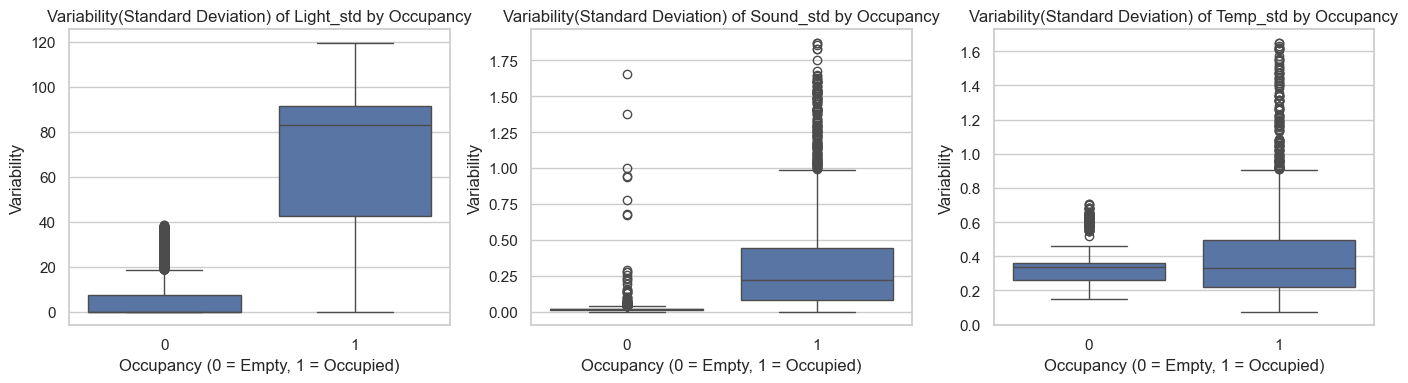

In [74]:
#feature extracted standard deviation features
std_features =["Light_std", "Sound_std", "Temp_std"]

#Group by occupancy and computing the mean variability
variability_summary = df.groupby("occupancy_binary")[std_features].mean()
print(variability_summary)
#plot
plt.figure(figsize=(14, 4))

for i, col in enumerate(std_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="occupancy_binary", y=col, data=df)
    plt.title(f"Variability(Standard Deviation) of {col} by Occupancy")
    plt.xlabel("Occupancy (0 = Empty, 1 = Occupied)")
    plt.ylabel("Variability")
plt.tight_layout()
plt.show()

The variability in light levels (light_std) shows a very strong difference between occupied and unoccupied states. When the room is empty, the average Light_std is 5.17, indicating almost no fluctuation in illumination. During occupied periods, the average Light_std increases to 70.04, which is more than very high than when unoccupied. The boxplot also shows a much wider spread and higher maximum values during occupancy. This shows that human activity leads to frequent and substantial changes in lighting, such as switching lights on/off or moving through illuminated areas, making Light_std a strong indicator of occupancy.

Sound variability(sound_std) also increases during occupied periods. When unoccupied, the average Sound_std is only 0.017, showing that sound levels remain nearly constant and quiet. During occupancy, Sound_std rises to 0.343, which is approximately 20 times higher. The boxplot for occupied periods shows a larger spread, with many values exceeding 0.5 and some reaching up to 1.8, compared to the unoccupied state, where almost all are close to zero. This indicates that even minor human activities, such as talking, movement, create noticeable fluctuations in sound, making Sound_std a highly sensitive occupancy-related feature.

Temperature variability shows a smaller but still measurable increase during occupied periods. When the room is empty, Temp_std averages 0.319, while during occupancy it increases to 0.400, representing about a 25% rise. The boxplot shows that occupied periods have a broader range, with maximum values exceeding 1.5, compared to unoccupied periods where variability is below 0.6. Although temperature changes are subtle compared to light and sound, the higher Temp_std during occupancy shows small heat fluctuations caused by human presence and sensor differences, making it a useful feature.

# **Impact of Combined Sensor Features on Occupancy Levels**

### **Do higher values of Motion_Light and Sound_Light correspond to multi-person occupancy?**

Analyzing this feature constructed variable helps us understand how many people are in the room, not just if the room is occupied or empty. We want to see if higher levels of Motion_Light or Sound_Light occur when more people are present.

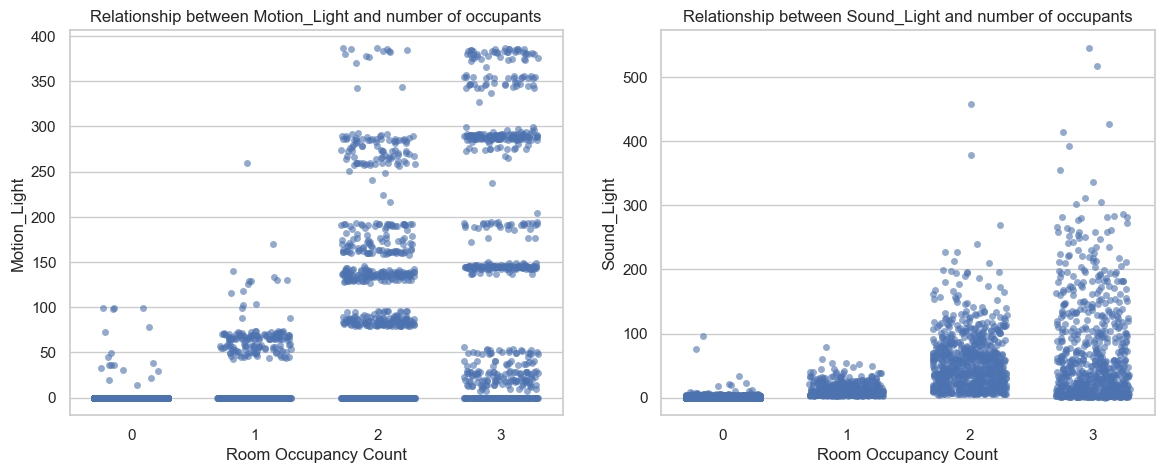

In [75]:
#select feature constructed variables
interaction_cols = ['Motion_Light', 'Sound_Light']

#side by side plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i,col in enumerate(interaction_cols):
    #Scatter plot with jitter to show distribution per occupancy
    sns.stripplot(x='Room_Occupancy_Count', y=col, data=df, jitter=0.3, alpha=0.6,ax=axes[i])
    axes[i].set_title(f'Relationship between {col} and number of occupants')
    axes[i].set_xlabel('Room Occupancy Count')
    axes[i].set_ylabel(col)
plt.show()

The Motion_Light feature shows a positive correlation  as the number of people in the room increases, the Motion_Light value also tends to increase. This suggests that more occupants generate more motion and higher light levels (from turning on lights), making this combined feature a strong predictor of occupancy count.

Similarly, the Sound_Light feature shows an even more pronounced relationship. Higher room occupancy counts are strongly associated with higher Sound_Light values. This indicates that the combination of increased noise levels and altered lighting conditions is a highly effective feature for distinguishing not just presence, but the actual number of occupants.

# **Evaluating Aggregated Sensor Feature by occupancy**

## **How do aggregated features(Temp_mean, Light_mean, Sound_mean, PIR_sum) provide stronger separation than individual sensors?**

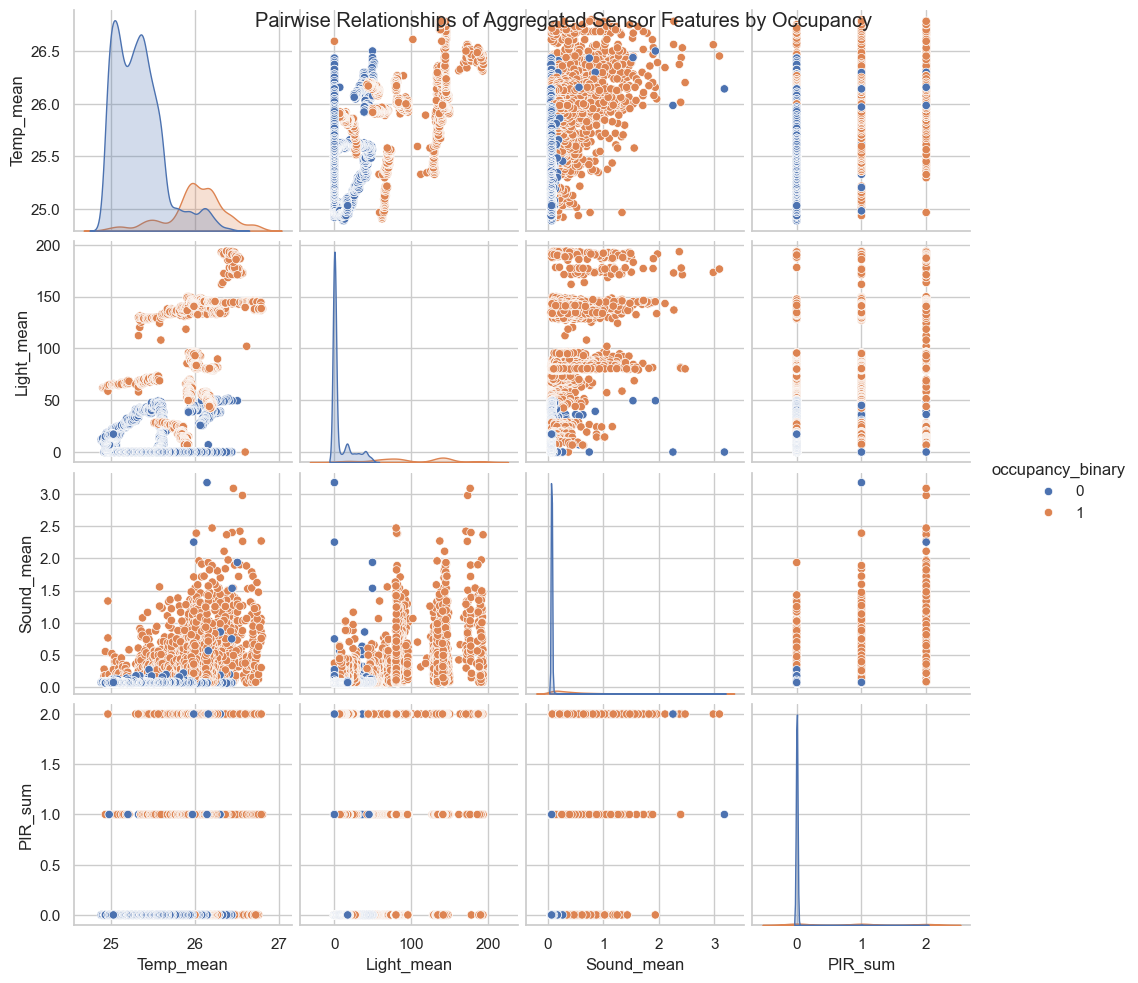

In [76]:
#Select aggregated features of sensors and occupancy
features_tot=['Temp_mean','Light_mean','Sound_mean','PIR_sum','occupancy_binary']
sns.pairplot(df[features_tot], diag_kind='kde', hue = 'occupancy_binary')
plt.suptitle("Pairwise Relationships of Aggregated Sensor Features by Occupancy")
plt.show()

The pair plot shows that the aggregated sensor features help separate occupied and unoccupied more clearly than individual sensor readings would. When the room is occupied, the data points (orange) tend to show higher light levels, more sound, and more PIR motion activity, while the temperature varies only slightly. In contrast, during unoccupied times, the points (blue) cluster around very low light, low sound, and almost zero PIR movement. These clear differences across aggregated features make it easier to distinguish occupancy patterns. By combining sensor readings over time (using means and sums), the data becomes less noisy and shows more consistent patterns, resulting in stronger separation between the two occupancy classes across multiple feature pairs.

# **Evaluating Interaction Between Sensors during occupancy**

### **Do different sensors respond at different speeds when occupancy starts or ends?**

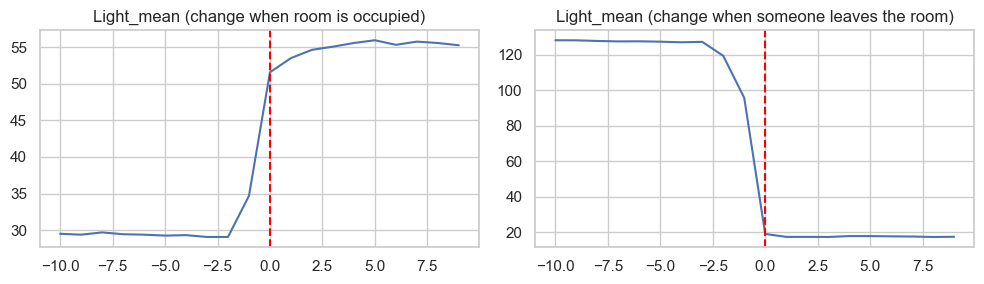

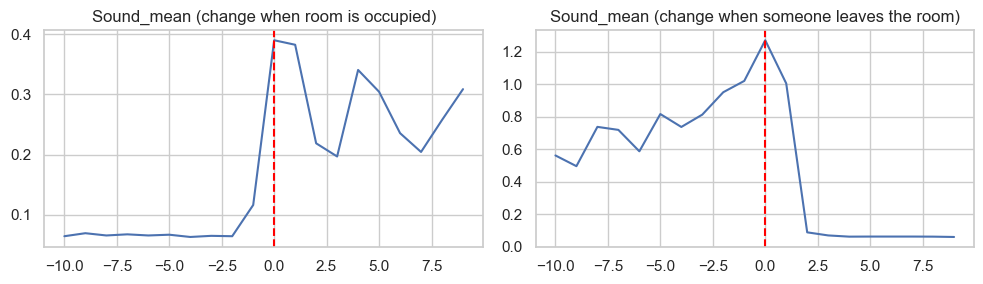

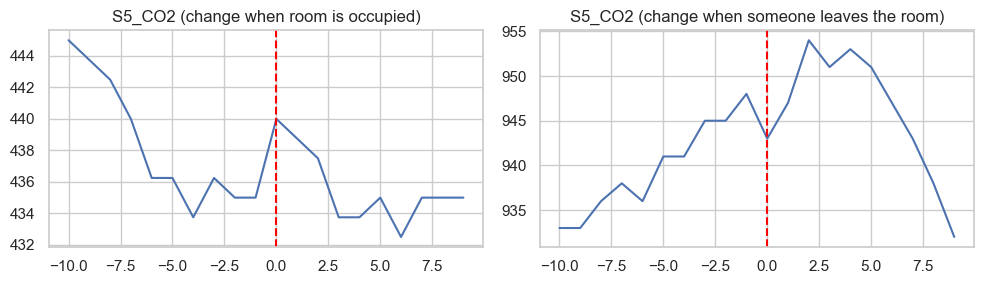

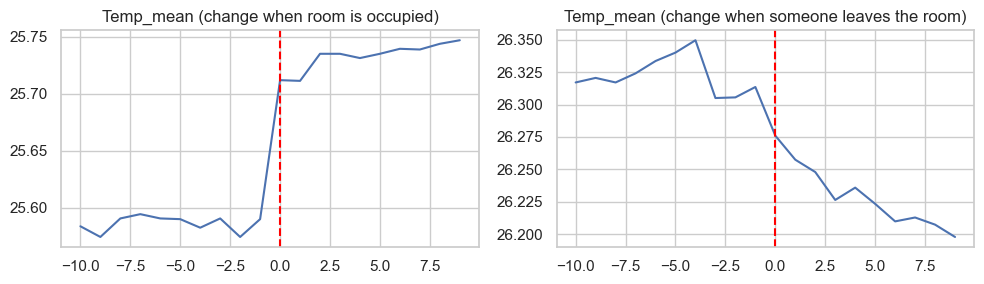

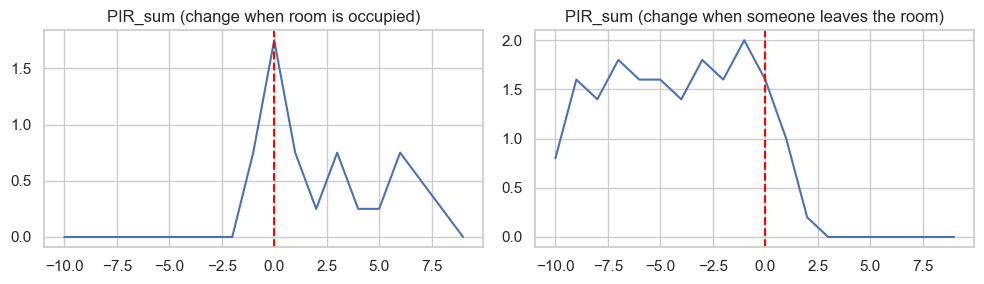

In [77]:
#combine the feature-engineered sensor variables
sensors = ["Light_mean", "Sound_mean", "S5_CO2", "Temp_mean", "PIR_sum"]
#samples around event
window = 10 

#Create event when occupancy changes by using diff()
df["start_event"] = (df["occupancy_binary"].diff() == 1)
df["end_event"]   = (df["occupancy_binary"].diff() == -1)

#define average sensor curve around change
def avg_curve(event_idx, col):
    curves = []
    for i in event_idx:
        seg = df[col].iloc[max(0, i-window): i+window]
        seg.index = range(-len(seg[:window]), len(seg[window:]))
        curves.append(seg)
    return pd.concat(curves, axis=1).mean(axis=1)

#event start(when someone enters)  and event end(someone leaves)
start_idx = df.index[df["start_event"]]
end_idx   = df.index[df["end_event"]]

# plot for each sensor
for col in sensors:
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(avg_curve(start_idx, col))
    plt.axvline(0, color="red", linestyle="--")
    plt.title(col + " (change when room is occupied)")

    plt.subplot(1,2,2)
    plt.plot(avg_curve(end_idx, col))
    plt.axvline(0, color="red", linestyle="--")
    plt.title(col + " (change when someone leaves the room)")
    plt.tight_layout()
    plt.show()

Each plot shows how a sensor’s value changes before and after an occupancy event. The red dashed line (x = 0) marks the exact moment when the event happens. On the left column, the event is someone entering the room (room becomes occupied). On the right column, the event is someone leaving the room (room becomes unoccupied). 

Across all sensors, we can see that they respond in different ways and at different speeds.



PIR and Sound respond immediately at the red line because movement and noise occur the moment a person enters or leaves. Light also changes quickly, rising sharply when the room becomes occupied and dropping immediately when it becomes empty, likely due to automated lighting. CO2 and temperature change much more slowly. CO2 gradually increases after someone enters as exhaled air accumulates, and decreases slowly after they leave. Temperature follows the same slow pattern because the Human body's heat affects the room temperature, but only gradually. Overall, the plots show that fast-reacting sensors (PIR, Sound, Light) react immediately to human presence, while environmental conditions like air quality and temperature take time to change.

### **Does light increase only when PIR is triggered?**

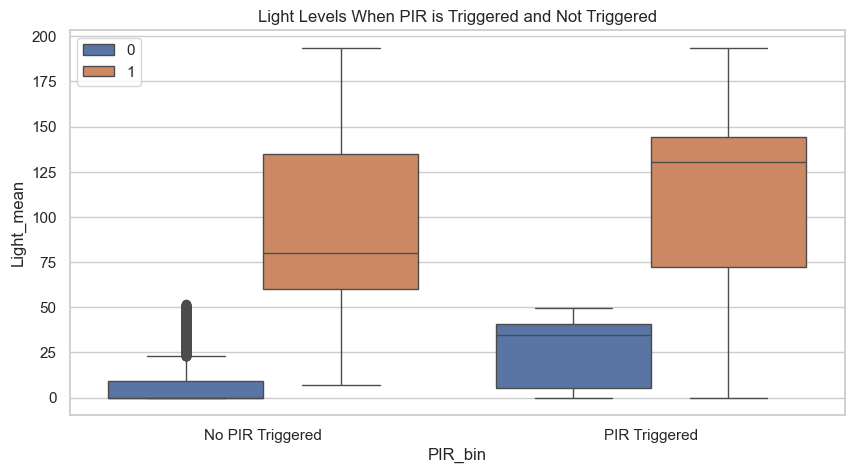

In [78]:
#Create a binary for PIR detection using our aggregated feature
df["PIR_bin"] = (df["PIR_sum"] > 0).astype(int)
plt.figure(figsize=(10,5))
#boxplot for lights vs pir_bin by occupancy
sns.boxplot(x="PIR_bin", y="Light_mean", hue="occupancy_binary", data=df)
plt.xticks([0,1], ["No PIR Triggered", "PIR Triggered"])
plt.title("Light Levels When PIR is Triggered and Not Triggered")
plt.legend(loc='upper left')
plt.show()

The boxplot shows the difference in light levels when the PIR sensor is triggered and when it is not. 

When PIR is not triggered, light levels are very low for both occupied and unoccupied periods, suggesting the room is typically dark or minimally lit when there is no motion. 

When PIR is triggered, light levels rise significantly, especially during occupied times, indicating that motion events are strongly associated with brighter lighting because lights turn on or increase when people move.

However, the plot also shows that light does not increase only when PIR is triggered(light is high even when occupancy = 1 but PIR = 0.) There are some occupied periods with relatively higher light even when PIR is not triggered, which likely happens when a person is present but not moving enough to activate the PIR sensor. Light may also stay on for a while after a motion event.

Light increases most of the time when PIR is triggered, but light does not increase only when PIR is triggered and presence of higher light levels does not depend only on PIR activity.

# **Sensor Contribution Analysis**

### **Which individual, aggregated metrics and engineered features have the strongest linear relationship with occupancy?**

<bound method IndexOpsMixin.tolist of S1_Light        0.928229
Light_std       0.865105
Light_mean      0.838022
S3_Light        0.743857
S2_Light        0.709844
PIR_sum         0.698709
S5_CO2_Slope    0.697825
S1_Temp         0.696657
Temp_mean       0.670177
S6_PIR          0.637159
Sound_mean      0.622344
S2_Temp         0.620816
Motion_Light    0.620672
S3_Temp         0.620412
Sound_std       0.619217
S7_PIR          0.600499
S1_Sound        0.599661
Sound_Light     0.594831
S5_CO2          0.586963
S5_CO2          0.586963
S4_Temp         0.550673
S2_Sound        0.527024
S3_Sound        0.474591
S4_Light        0.423035
S4_Sound        0.416515
Temp_std        0.221810
Name: occupancy_binary, dtype: float64>


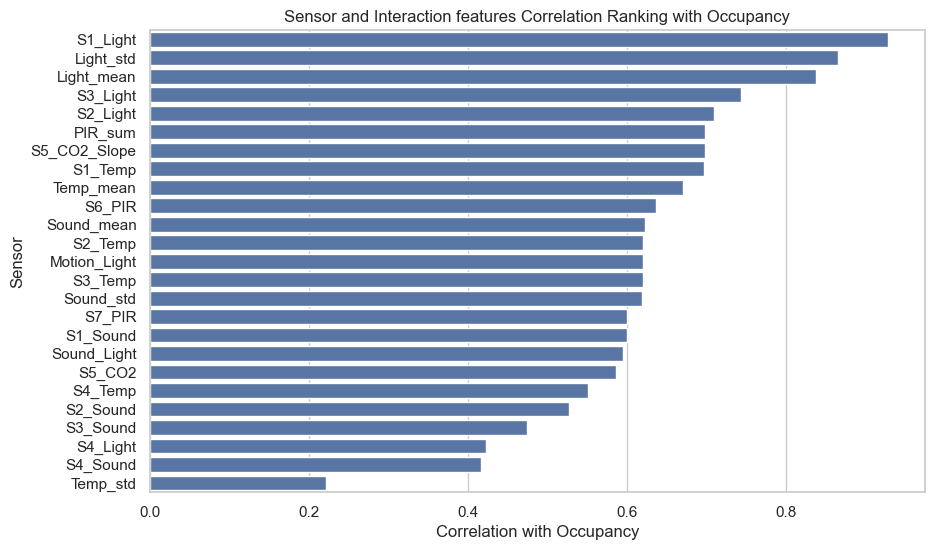

In [79]:
#select all features including aggregated sensors, single sensors, and engineered features
all_features = sensor_cols+sensors+interaction_cols + std_features + ['occupancy_binary']
# Compute correlation with occupancy
corr_with_occupancy = df[all_features].corr()['occupancy_binary'].drop('occupancy_binary')
#Sort descending to get ranking
corr_ranking = corr_with_occupancy.sort_values(ascending=False)
print(corr_ranking.to_list)
#Plot
plt.figure(figsize=(10,6))
sns.barplot(x=corr_ranking.values, y=corr_ranking.index)
plt.title("Sensor and Interaction features Correlation Ranking with Occupancy")
plt.xlabel("Correlation with Occupancy")
plt.ylabel("Sensor")
plt.show()

The plot shows that light related sensor features have the strongest linear relationship with occupancy. The single sensor S1_Light and the aggregated metric Light_mean are the top two predictors, indicating that an increase in light intensity is the most reliable predictor that a room is occupied.

Following these, the aggregated PIR_sum and the S5_CO2_Slope are also highly correlated, highlighting that combined motion events and the rate of change in CO2 are strong indicators.

The engineered feature Motion_Light shows a significant correlation,showing that the co-occurrence of motion and light is a powerful predictor. The sound-related features (Sound_mean, Sound_Light) and the raw S5_CO2 level are among the weakest predictors, suggesting they have a less consistent linear relationship with occupancy.


# **CO2 and Temperature Variation Across the Day by Occupancy Status**

### **How do CO2 levels and Temperature vary across the day under both occupied and not occupied condition?**

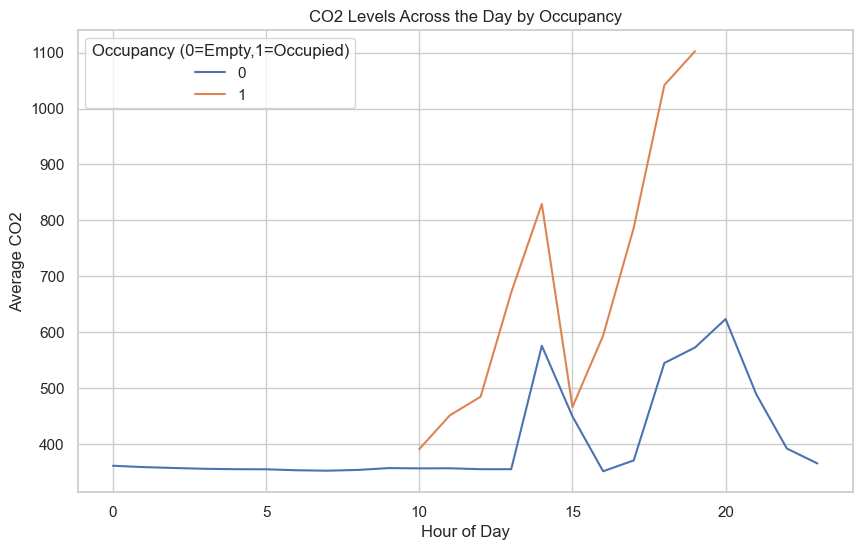

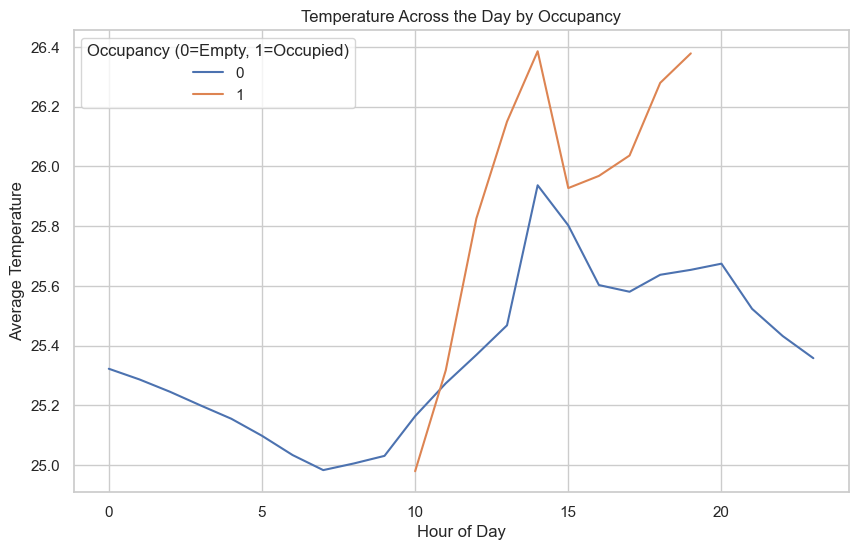

In [80]:
hourly_stats =df.groupby(['hour','occupancy_binary'])[['S5_CO2', 'Temp_mean']].mean().reset_index()

#Line plot for CO2 and temperature through the day by occupancy
plt.figure(figsize=(10,6))

sns.lineplot(data=hourly_stats, x='hour', y='S5_CO2',hue='occupancy_binary')
plt.title("CO2 Levels Across the Day by Occupancy")
plt.xlabel("Hour of Day")
plt.ylabel("Average CO2")
plt.legend(title="Occupancy (0=Empty,1=Occupied)")
plt.grid(True)
plt.show()

# Temperature plot
plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_stats, x='hour', y='Temp_mean',hue='occupancy_binary')
plt.title("Temperature Across the Day by Occupancy")
plt.xlabel("Hour of Day")
plt.ylabel("Average Temperature")
plt.legend(title="Occupancy (0=Empty, 1=Occupied)")
plt.grid(True)
plt.show()

The plots shows patterns for both CO2 and temperature changes in occupied versus unoccupied rooms.

When the room is occupied (blue line), the CO2 level is higher all day. It shoots up during the middle of the day, which is likely when the room is busiest. This pattern reflects human respiration, confirming that CO2 is a strong indicator of presence.

When the room is empty (red line), the CO2 level stays stable and shows low-level readings.

For Temperature, both occupied and unoccupied rooms follow a similar daily temperature cycle; the occupied state consistently maintains a slightly elevated temperature, likely due to body heat and equipment use.

In summary, occupancy clearly impacts both environmental factors; it causes a large, variable increase in CO2 and a smaller, constant increase in temperature throughout the day.



# **Sudden Sensor Spikes Analysis**

### **Do sudden increases in light, sound, CO₂, or motion readings reflect actual human activity, or are they caused by irregular sensor fluctuations?**

Sharp changes in sensor values often means human presence, and understanding these patterns helps to determine whether the sensors are reliably capturing real occupancy events.

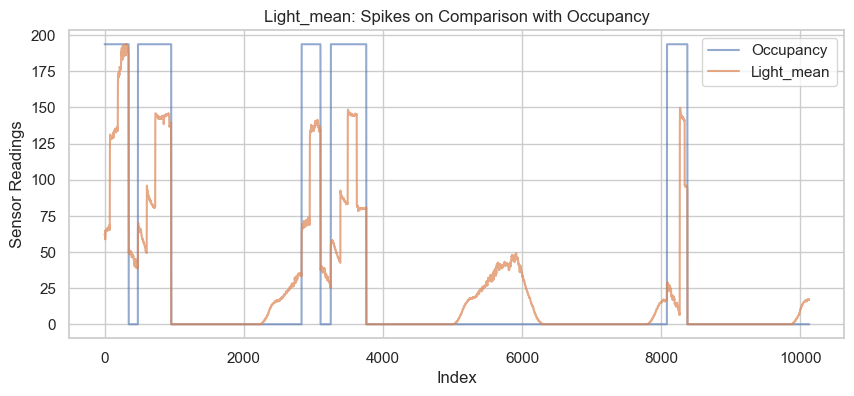

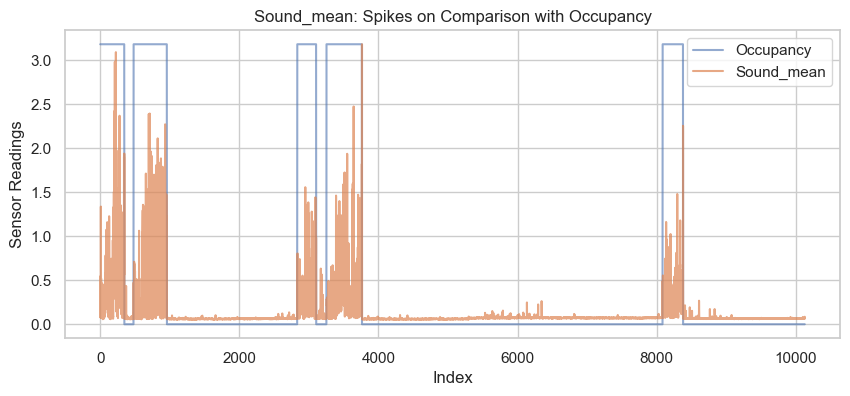

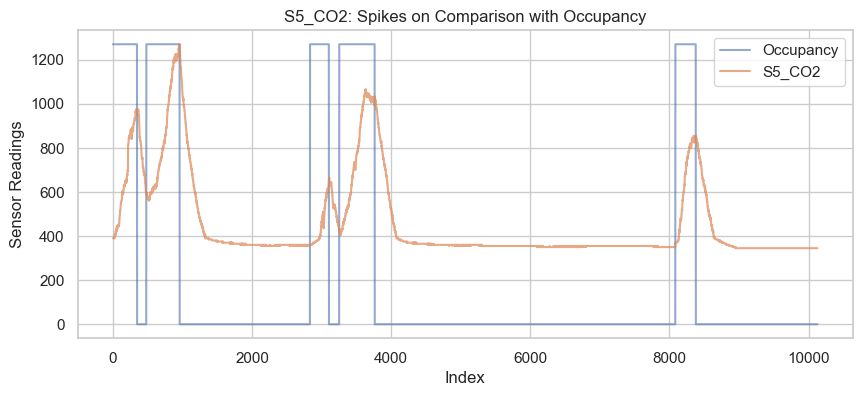

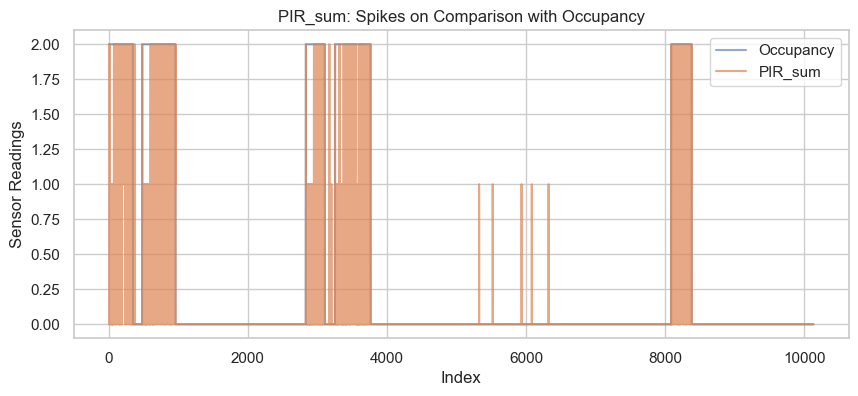

In [81]:
key_sensors = ["Light_mean", "Sound_mean", "S5_CO2", "PIR_sum"]

for col in key_sensors:
    if col in df.columns:
        plt.figure(figsize=(10,4))

         #scale occupancy so it appers on same graph
        occu_scaled = df["occupancy_binary"]* df[col].max()
        plt.plot(occu_scaled.values, label="Occupancy", alpha=0.6)

        #plot the sensor values
        plt.plot(df[col].values, label=col, alpha=0.7)
        plt.title(f"{col}: Spikes on Comparison with Occupancy")
        plt.xlabel("Index")
        plt.ylabel("Sensor Readings")
        plt.legend(loc='upper right')
        plt.show()

The orange line shows sensor spikes, and the blue line shows occupancy. There is no spiking when the room is empty, which rules out irregular sensor fluctuations as a major cause. Sensor spikes align with periods of confirmed occupancy, providing strong evidence that these are genuine signals of human activity. These sensors are effectively capturing real-world occupancy events.

Light_mean: The spike in light intensity directly coincides with the room occupancy (blue line rises). When the room is unoccupied, light levels consistently drop to near zero. This shows lights are turned on by people entering and turned off when they leave.

Sound_mean: Sharp peaks in sound consistently occur when the room is occupied. The sensor is quiet when the room is empty, confirming that the spikes represent human-generated noise like conversation or movement.

S5_CO2: The CO2 level rises gradually after the room becomes occupied (blue line shifts) and decays slowly after it becomes empty, showing the accumulation of human exhaling. The large spikes are a direct result of human presence.

PIR_sum: The motion sensor data is the most precise. Its spikes are short, sharp, and occur only during occupied periods. This perfectly captures individual motion.

# **MODELING**

Our feature selection for modelling will be based on most informative and non-redundant features that are strong indicators of occupancy based on EDA. This includes aggregated features and engineered features, which are derived from individual sensors. Raw sensor values were not used due to high noise and redundancy, and mean values were avoided because standard deviation features showed clearer separation between occupied and unoccupied periods. These four features gave the best combination of predictive power for the occupancy detection model.This avoids redundancy from highly correlated raw sensors (S1_Light–S4_Light, S1_PIR–S7_PIR)and improves models' interpretability, also reduces overfitting, speeds up training.

In [82]:
#import all libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

### **Select features**

S5_CO2 was selected because CO2 levels rise when people are present, making it a strong and stable indicator of occupancy. It showed clear differences between occupied and unoccupied periods.

Sound_std captures variability in noise, which increases when people move or talk. It is more useful than raw sound values and mean because unoccupied rooms have low and steady sound levels.

Motion_Light combines PIR motion with light intensity, creating a reliable signal of human activity. This reduces multicollinearity while retaining the most informative aspects of light-based behavior, making Motion_Light a more effective predictor than using separate light features.

Temp_std shows small temperature fluctuations caused by people in the room. While temperature means stay similar, variability increases during occupancy, making Temp_std more informative.

In [83]:
#Select the most revelent features for analysis
features=['Sound_std', 'Temp_std', 'S5_CO2', 'Motion_Light']

In [84]:
#Select features and target
X = df[features]
y = df['occupancy_binary']

### **Test train Split**

In [85]:
#Split data in 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [86]:
#verify split
print(f"Training size: {len(X_train)} rows ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing size: {len(X_test)} rows ({len(X_test)/len(X)*100:.1f}%)")

Training size: 7090 rows (70.0%)
Testing size: 3039 rows (30.0%)


### Handling class Imbalance by SMOTE

In [87]:
#Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

## **LOGISTIC REGRESSION(Base line model)**

### STANDERDISATION

In [88]:
#Scaling the features using standard scaler for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

In [89]:
#Logistic reg model with regularisation to prevent overfitting ,class weight handles imbalance
log_model = LogisticRegression(max_iter=200, C=0.01, class_weight='balanced')

#fit train the training data
log_model.fit(X_train_scaled, y_train_sm)

#predict occupancy(0 or1) for x test data
y_pred_lr = log_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2469
           1       0.79      0.88      0.83       570

    accuracy                           0.93      3039
   macro avg       0.88      0.91      0.89      3039
weighted avg       0.94      0.93      0.93      3039



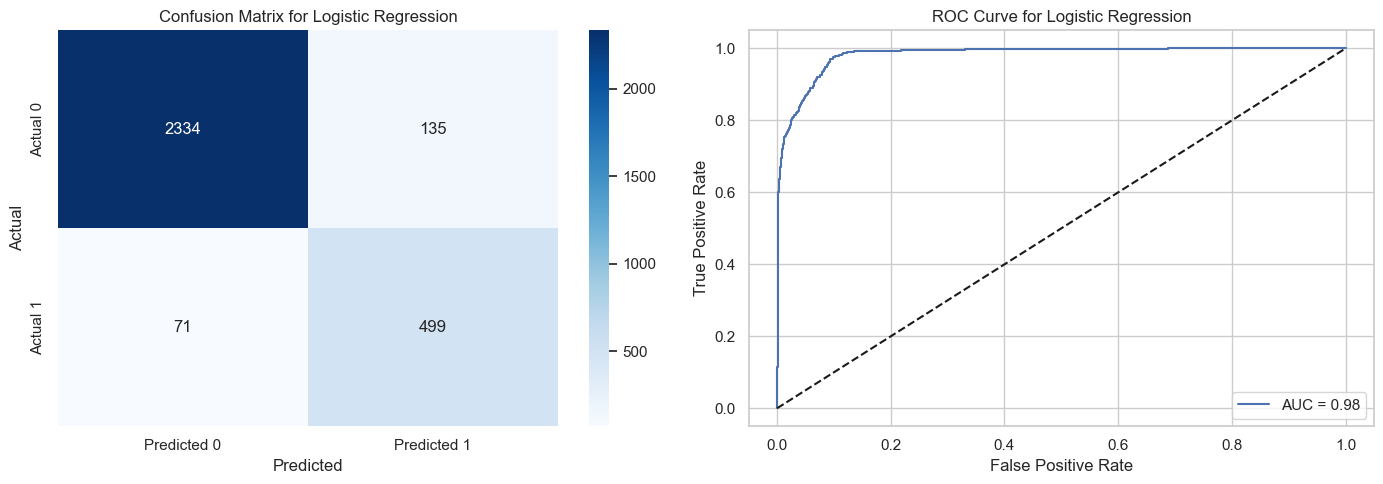

In [90]:
#Predict probabilities for ROC curve
y_prob_lr = log_model.predict_proba(X_test_scaled)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
#confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_score_lr = roc_auc_score(y_test, y_prob_lr)

#heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',xticklabels=['Predicted 0', 'Predicted 1'],yticklabels=['Actual 0', 'Actual 1'],ax=axes[0])
#label
axes[0].set_title("Confusion Matrix for Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

#plot ROC curve
axes[1].plot(fpr_lr, tpr_lr, label=f'AUC = {auc_score_lr:.2f}')
axes[1].plot([0,1], [0,1], 'k--')
axes[1].set_title("ROC Curve for Logistic Regression")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

The logistic regression baseline model has an overall accuracy score of 93 % showing moderate performance in predictiong room occupancy from sensor data.The model correctly identifies 2334 empty-room cases and 499 occupied-room cases, but it also generates 135 false alarms (predicting occupancy when the room is empty) and 71 missed detections (failing to identify occupancy). These errors directly reflect the imbalance between precision and recall for each class.

For class 0 (not occupied), the model has a precision of 0.97 and a high recall of 0.95, meaning it detects most empty rooms but sometimes misclassify them as occupied. For class 1 (occupied), precision is strong 0.79, indicating some false alarm. The recall is 0.88, meaning the model succesfuly detects most occupancy events but still misses some cases. Both classes have F1-scores around 0.96–0.83, confirming an imbalance between precision and recall.

Overall, while Logistic Regression provides a useful baseline and captures many true occupancy patterns but it struggles to reliably capture all true occupancy events, especially when people are actually present. More advanced models are needed for higher detection reliability.


## **DECISION TREE**

No scaling was applied because the decision tree models are scale-invariant

In [91]:
dt_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=200,class_weight='balanced', random_state=42)

In [92]:
#fit train the data
dt_model.fit(X_train_sm, y_train_sm)
#predict on test data
y_pred_dt = dt_model.predict(X_test)

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2469
           1       0.84      0.98      0.90       570

    accuracy                           0.96      3039
   macro avg       0.92      0.97      0.94      3039
weighted avg       0.96      0.96      0.96      3039



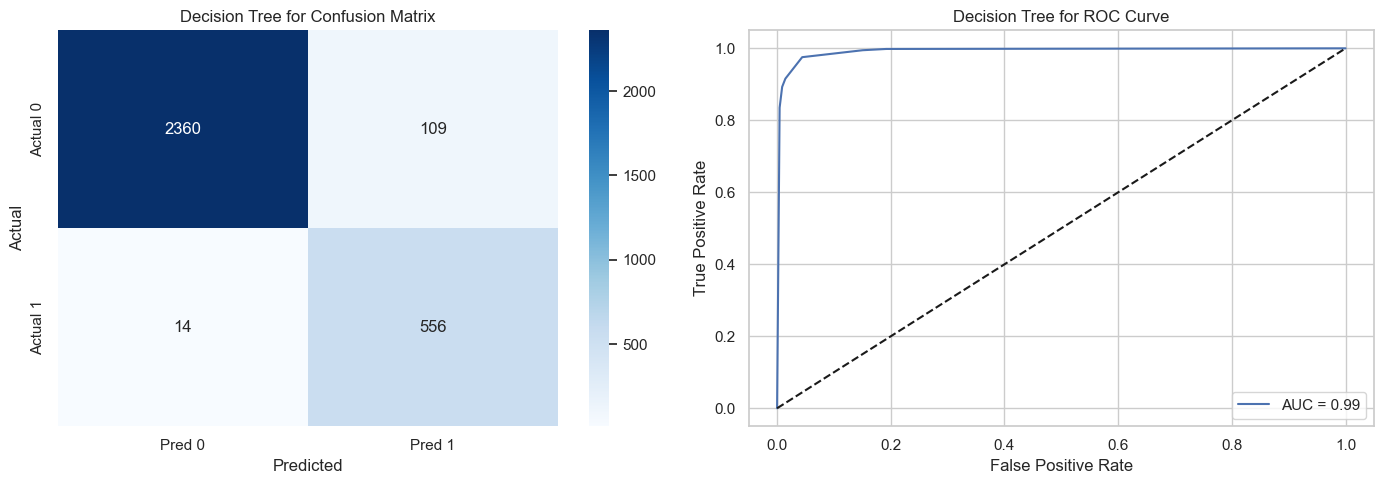

In [93]:
#calculate prediction probabilities
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

#subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',xticklabels=['Pred 0', 'Pred 1'],yticklabels=['Actual 0', 'Actual 1'],ax=axes[0])
axes[0].set_title("Decision Tree for Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

#plot ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
auc_dt = roc_auc_score(y_test, y_prob_dt)
axes[1].plot(fpr_dt, tpr_dt, label=f"AUC = {auc_dt:.2f}")
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title("Decision Tree for ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

The Decision Tree model shows strong performance, achieving an overall accuracy of 96%, indicating that it can reliably distinguish between occupied and unoccupied room states using IoT sensor data. The confusion matrix shows that the model correctly identified 2360 empty-room cases and 556 occupied-room cases, with only 109 false positives and 190 false negatives.This means the model rarely fails to detect occupied rooms and has a low rate of incorrect occupancy alerts. 
The classification report further supports this result. For class 0 (not occupied), the model achieves a precision of 0.99 and recall of 0.96, meaning it mostly identifies empty rooms correctly. For class 1 (occupied), precision is 0.84, showing that predicted occupancy is almost always accurate, while recall of 0.98 indicates it correctly detects most occupied instances. Both classes achieve an F1-score of 0.97, confirming a stable balance between precision and recall.

Overall, the Decision Tree provides greater accuracy over logistic regression, especially in correctly identifying occupied rooms,showing that environmental sensor patterns contain meaningful non-linear relationships that a tree-based model can successfully capture.

## **RANDOM FOREST**

No scaling was applied because the Random Forest is scale-invariant.

In [94]:
#Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf=200, class_weight='balanced',random_state=42)
# Fit train
rf_model.fit(X_train_sm, y_train_sm)
#Predict on test
y_pred_rf = rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2469
           1       0.88      0.96      0.92       570

    accuracy                           0.97      3039
   macro avg       0.94      0.96      0.95      3039
weighted avg       0.97      0.97      0.97      3039



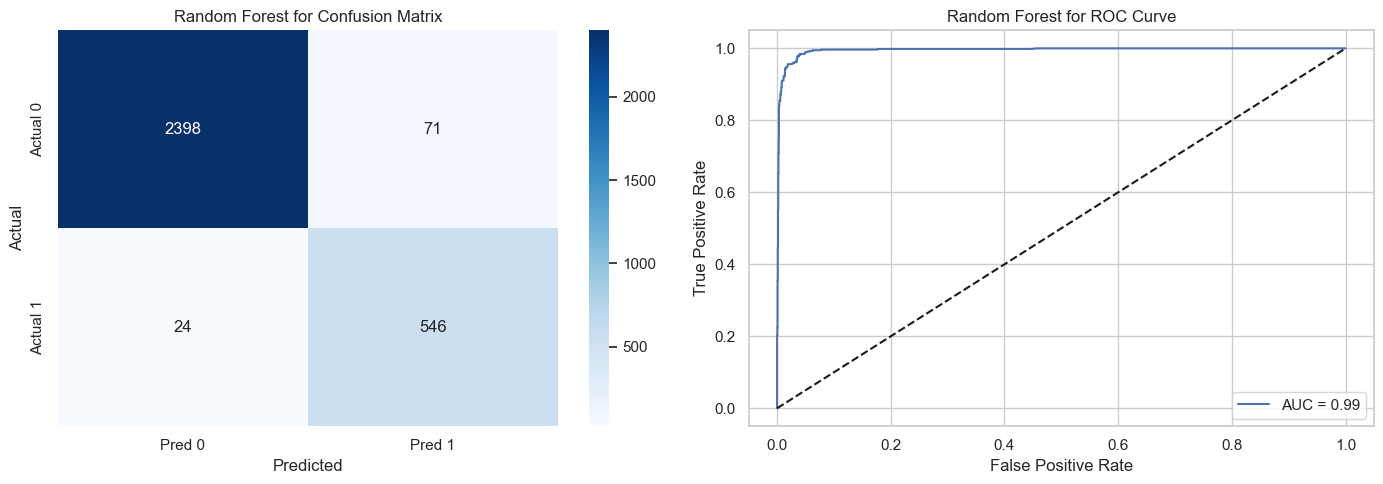

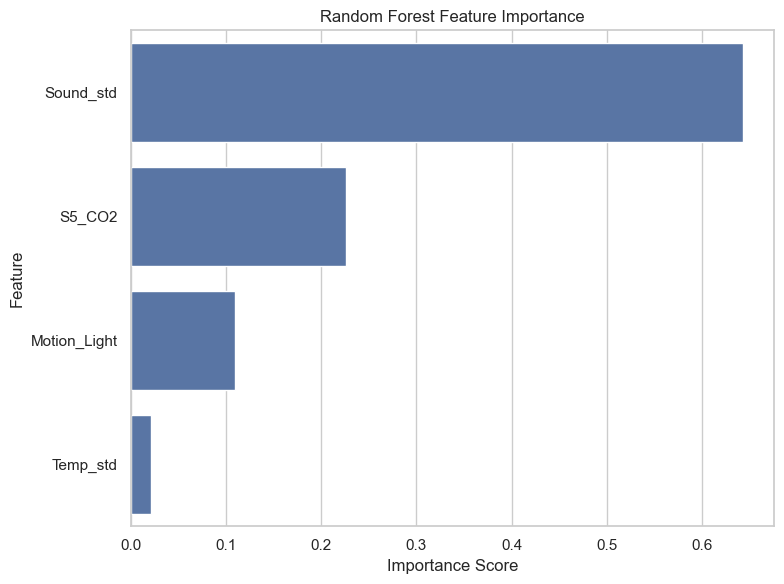

In [95]:
#calculat probabilities
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

#plot Confusion matrix and Roc curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',xticklabels=['Pred 0', 'Pred 1'],yticklabels=['Actual 0', 'Actual 1'],ax=axes[0])
axes[0].set_title("Random Forest for Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

#ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)
axes[1].plot(fpr_rf, tpr_rf, label=f"AUC = {auc_rf:.2f}")
axes[1].plot([0,1], [0,1], 'k--')
axes[1].set_title("Random Forest for ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

#feature Importance plot for random forest
importances = rf_model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X_train.columns,'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The Random Forest model achieves an overall accuracy of 97%, which performs exceptionally well in predicting room occupancy compared to baseline logistic regression model. The confusion matrix shows that the model correctly identifies 2398 out of 2469 unoccupied cases and 546 out of 570 occupied cases (96% recall), indicating extremely low misclassification rates for both classes.For unoccupied rooms (class 0), the model precision is 0.99 and F1-score of 0.98, meaning it correctly identifies unoccupied rooms. For occupied rooms (class 1), precision reaches 0.88 with an F1-score of 0.92, meaning the model accurately detects most true occupancy with minimal false alarms.

The feature importance results show that CO2 levels (S5_CO2), Sound variability (Sound_std), and the engineered Motion_Light interaction feature contribute the most to accurate predictions. This confirms that human activity significantly affects air quality, sound patterns, and combined motion–light behavior.

Overall, the Random Forest model shows high predictive power, strong generalization, and business reliability, making it suitable for real-world applications such as optimizing HVAC usage, automating lighting systems, and monitoring space utilization with measurable confidence.

In [96]:
# Data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

# SMOTE for imbalance
from imblearn.over_sampling import SMOTE


# **Support Vector Machine (SVM)**

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2469
           1       0.89      0.97      0.93       570

    accuracy                           0.97      3039
   macro avg       0.94      0.97      0.95      3039
weighted avg       0.97      0.97      0.97      3039



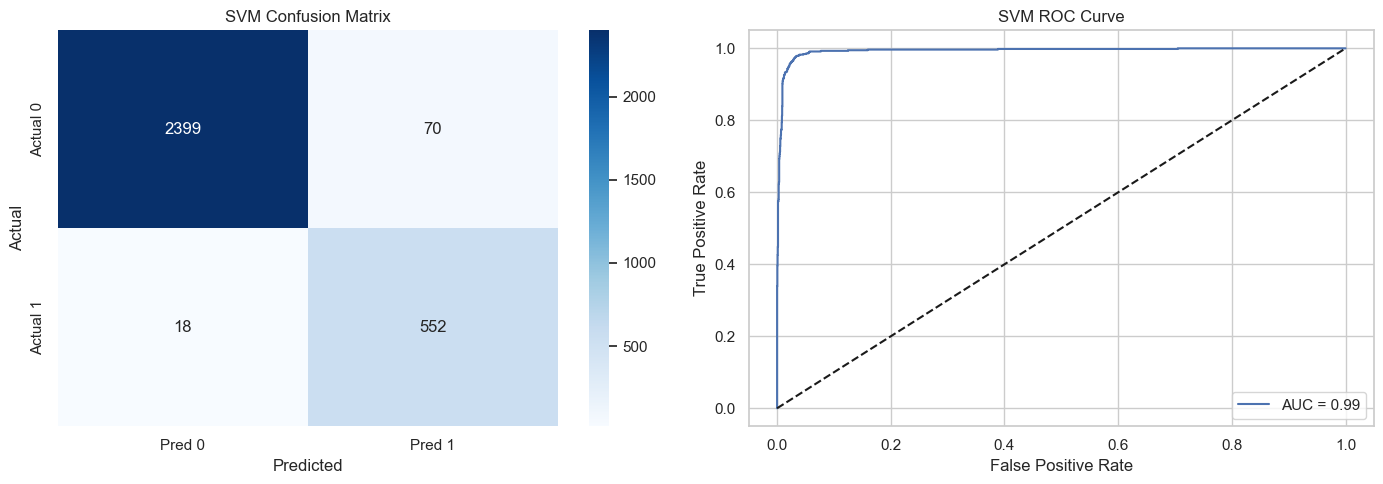

In [ ]:
# model
svm_model = SVC(kernel='rbf',
                class_weight='balanced',
                probability=True,
                random_state=42)

svm_model.fit(X_train_scaled, y_train_sm)

y_pred_svm = svm_model.predict(X_test_scaled)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# calculating probabilities for ROC
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title("SVM Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
auc_svm = roc_auc_score(y_test, y_prob_svm)
axes[1].plot(fpr_svm, tpr_svm, label=f"AUC = {auc_svm:.2f}")
axes[1].plot([0,1], [0,1], 'k--')
axes[1].set_title("SVM ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


The Support Vector Machine (SVM) model performs extremely well, achieving an overall accuracy of 97%, placing it alongside the best-performing models in predicting room occupancy from sensor data. The confusion matrix shows the model correctly identifies 2399 out of 2469 unoccupied cases and 552 out of 570 occupied cases, indicating very low misclassification rates for both classes. With only 70 false positives and 18 false negatives, the model demonstrates strong reliability in distinguishing between occupied and unoccupied states.

The classification report reinforces this performance. For class 0 (not occupied), the model reaches a precision of 0.99 and a recall of 0.97, meaning it almost perfectly identifies empty rooms while keeping false occupancy alerts minimal. For class 1 (occupied), the model achieves a precision of 0.89 and a high recall of 0.97, showing that it reliably detects true occupancy events with very few missed cases. The F1-scores of 0.98 for class 0 and 0.93 for class 1 indicate a strong balance between precision and recall.

The ROC curve further highlights SVM’s predictive strength, with an AUC score of 0.99, demonstrating exceptional separability between the two classes. Overall, the SVM model captures complex patterns in environmental sensor data and delivers high classification performance, making it a strong candidate for real-time occupancy detection tasks.

# **K-Nearest Neighbors (KNN)**

KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2469
           1       0.95      0.99      0.97       570

    accuracy                           0.99      3039
   macro avg       0.97      0.99      0.98      3039
weighted avg       0.99      0.99      0.99      3039



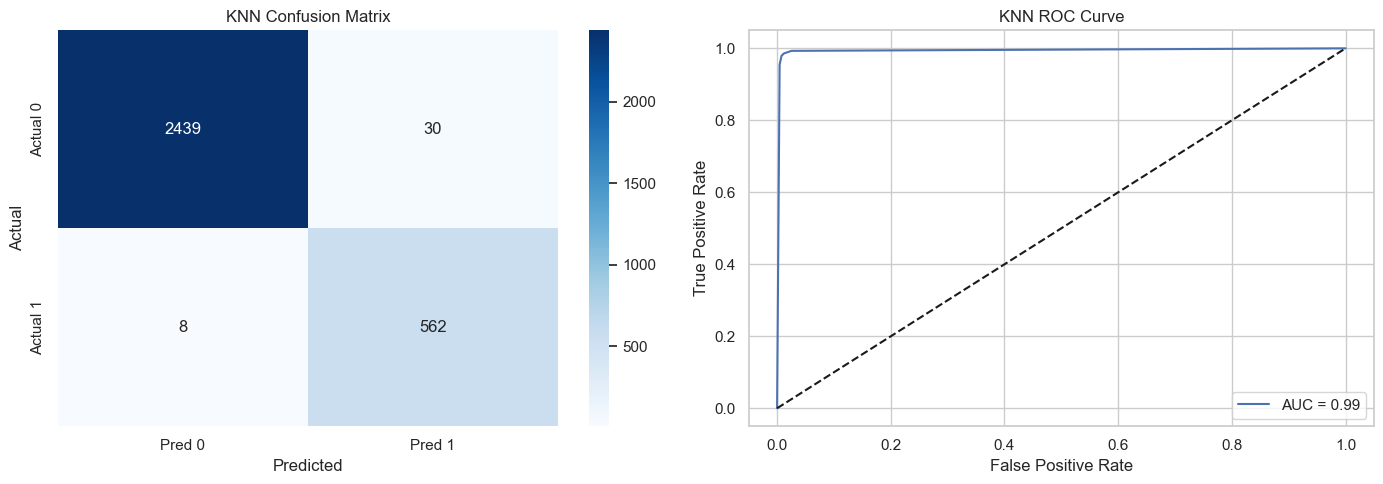

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train_scaled, y_train_sm)

y_pred_knn = knn_model.predict(X_test_scaled)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# calculating probabilities for ROC
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title("KNN Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
auc_knn = roc_auc_score(y_test, y_prob_knn)
axes[1].plot(fpr_knn, tpr_knn, label=f"AUC = {auc_knn:.2f}")
axes[1].plot([0,1], [0,1], 'k--')
axes[1].set_title("KNN ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


The K-Nearest Neighbors (KNN) model demonstrates exceptionally strong performance, achieving an overall accuracy of 99%, the highest among all evaluated models. The confusion matrix shows the model correctly classified 2439 out of 2469 unoccupied cases and 562 out of 570 occupied cases, with only 38 total misclassifications. This reflects a very low error rate in predicting both occupancy and non-occupancy.

For class 0 (not occupied), KNN achieves perfect precision of 1.00 and a recall of 0.99, meaning the model almost never incorrectly labels an occupied room as empty. For class 1 (occupied), the model maintains high precision at 0.95 and recall at 0.99, indicating that it correctly detects nearly all occupancy events while minimizing false positives. F1-scores of 0.99 for class 0 and 0.97 for class 1 highlight an excellent balance between precision and recall.

The ROC curve further reinforces KNN’s performance, with an AUC of 0.99, showing near-perfect discrimination between occupied and unoccupied states. Overall, the KNN model provides outstanding predictive accuracy and stability, suggesting that the sensor data exhibits strong local patterns that KNN can capture effectively. Its reliability makes it highly suitable for real-time occupancy monitoring and smart-building automation tasks.

# **Naive Bayes**

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2469
           1       0.89      0.88      0.88       570

    accuracy                           0.96      3039
   macro avg       0.93      0.93      0.93      3039
weighted avg       0.96      0.96      0.96      3039



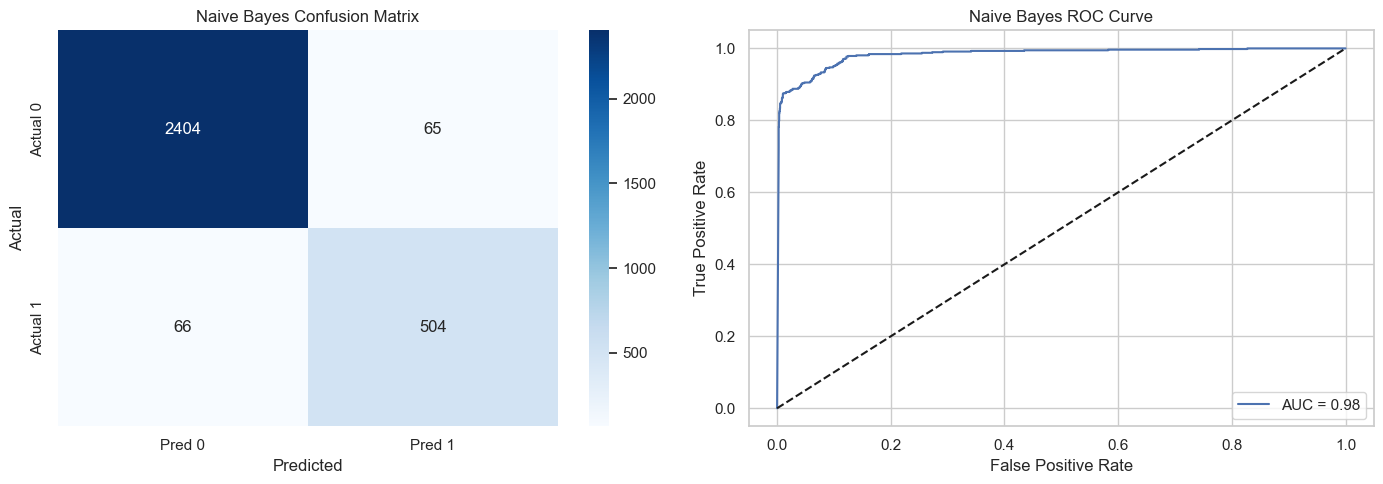

In [99]:
# model
nb_model = GaussianNB()

nb_model.fit(X_train_scaled, y_train_sm)

y_pred_nb = nb_model.predict(X_test_scaled)

print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

y_prob_nb = nb_model.predict_proba(X_test_scaled)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title("Naive Bayes Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
auc_nb = roc_auc_score(y_test, y_prob_nb)
axes[1].plot(fpr_nb, tpr_nb, label=f"AUC = {auc_nb:.2f}")
axes[1].plot([0,1], [0,1], 'k--')
axes[1].set_title("Naive Bayes ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


The Naive Bayes model achieves an overall accuracy of 96%, showing strong performance in predicting room occupancy based on sensor data. The confusion matrix indicates that the model correctly identifies 2404 out of 2469 unoccupied cases and 504 out of 570 occupied cases. With 65 false positives and 66 false negatives, the model maintains a relatively balanced error distribution across both classes.

The classification report supports these observations. For class 0 (not occupied), the model achieves high precision and recall scores of 0.97, demonstrating that it reliably identifies empty-room conditions with minimal false alarms. For class 1 (occupied), the model reaches a precision of 0.89 and recall of 0.88, meaning it correctly captures most occupancy events, though it misses some compared to tree-based and distance-based methods. The F1-scores of 0.97 for class 0 and 0.88 for class 1 highlight this performance difference across classes.

The ROC curve shows an AUC of 0.98, indicating excellent overall separability between occupied and unoccupied states. Overall, while Naive Bayes performs well and generalizes effectively, it does not capture the full complexity of environmental sensor interactions as strongly as models like KNN, SVM, or Random Forest. However, its simplicity and computational efficiency make it useful for lightweight deployment scenarios where speed and interpretability matter.

# **Best Model Performance**

Across all six models evaluated, K-Nearest Neighbors (KNN) demonstrated the strongest overall performance, achieving a 99% accuracy rate along with exceptional recall and F1-scores for both classes. The model correctly detected nearly all occupancy events while maintaining extremely low false-positive and false-negative rates. Support Vector Machine (SVM) and Random Forest followed closely behind, each achieving 97% accuracy with strong recall levels for the occupied class, indicating reliable detection of true occupancy patterns. Decision Tree and Naive Bayes also performed well, with accuracy levels of 96%, while Logistic Regression served as a useful baseline but showed noticeably lower precision and recall for the occupied class. 

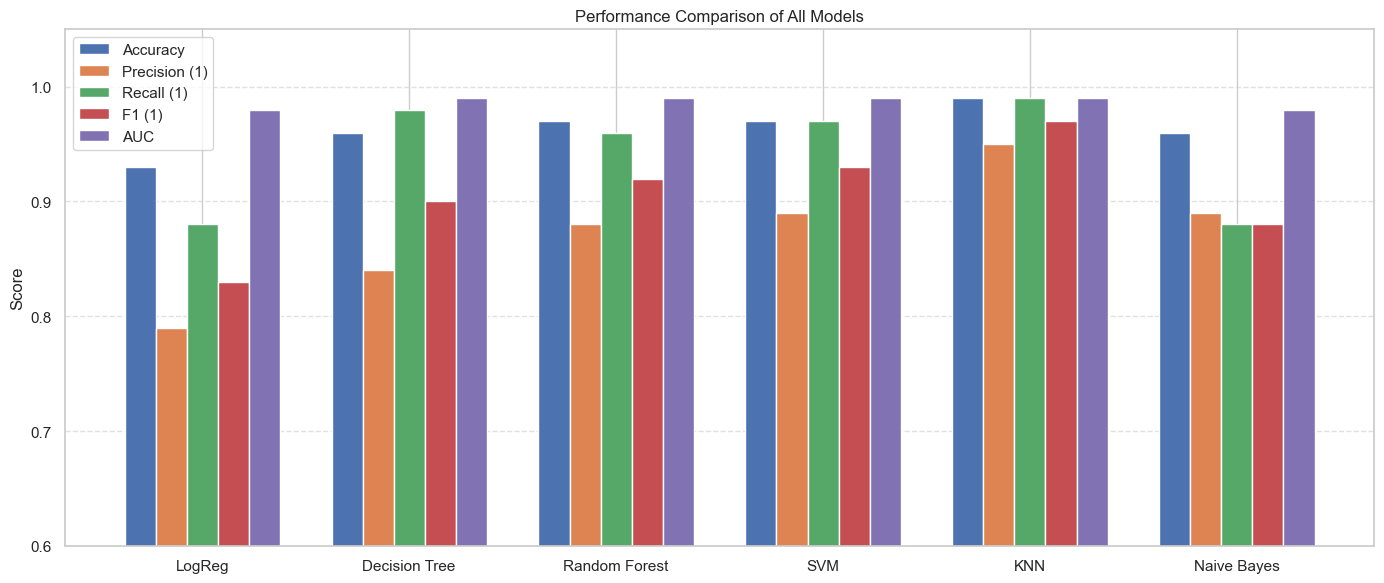

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# model names
models = ["LogReg", "Decision Tree", "Random Forest", "SVM", "KNN", "Naive Bayes"]

accuracy = [0.93, 0.96, 0.97, 0.97, 0.99, 0.96]

# precision (Class 1)
precision_1 = [0.79, 0.84, 0.88, 0.89, 0.95, 0.89]

# recall (Class 1)
recall_1 = [0.88, 0.98, 0.96, 0.97, 0.99, 0.88]

# F1 Score (Class 1)
f1_1 = [0.83, 0.90, 0.92, 0.93, 0.97, 0.88]

# AUC
auc = [0.98, 0.99, 0.99, 0.99, 0.99, 0.98]

plt.figure(figsize=(14, 6))

x = np.arange(len(models))
width = 0.15

plt.bar(x - 2*width, accuracy, width, label='Accuracy')
plt.bar(x - width, precision_1, width, label='Precision (1)')
plt.bar(x, recall_1, width, label='Recall (1)')
plt.bar(x + width, f1_1, width, label='F1 (1)')
plt.bar(x + 2*width, auc, width, label='AUC')

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Performance Comparison of All Models")
plt.legend()
plt.ylim(0.6, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


The comparison plot shows clear performance differences across all six models. Logistic Regression provides a reasonable baseline but struggles to capture more complex occupancy patterns. Decision Tree improves overall accuracy by modeling non-linear relationships in the sensor data.

Random Forest, SVM, and especially KNN deliver the strongest results, with high accuracy, strong recall, and AUC values near 0.99. KNN stands out as the top performer, indicating that occupancy signals form meaningful local clusters that this model captures very well. Naive Bayes performs consistently but does not match the precision and recall achieved by the top three models.

Overall, the plot highlights that models capable of learning non-linear or distance-based patterns—particularly KNN, SVM, and Random Forest—are best suited for predicting room occupancy from environmental sensor data.

# **Final Conclusion**

This project evaluated six machine learning models to determine which algorithms best predict room occupancy using environmental sensor data. The dataset included features such as sound levels, CO₂ concentration, temperature variation, and engineered interaction terms that reflect human presence patterns. After balancing the training data with SMOTE and standardizing the features, we trained and compared Logistic Regression, Decision Tree, Random Forest, Support Vector Machine, K Nearest Neighbors, and Naive Bayes.

The results show that machine learning models can reliably determine room occupancy from environmental sensor patterns, but their performance varies depending on how effectively they capture non linear or local relationships within the data. Simpler models such as Logistic Regression and Naive Bayes provide reasonable baseline performance but struggle to capture the more nuanced interactions among sound, CO₂ levels, motion, and temperature. Decision Tree improves upon these baselines by modeling more complex patterns in the data.

Random Forest, Support Vector Machine, and K Nearest Neighbors consistently deliver the strongest performance. These models achieve high accuracy, strong recall for detecting occupancy, and AUC scores close to 0.99, showing excellent separation between the two classes. They generalize well and reliably capture the underlying structure of the sensor data. Among all models, K Nearest Neighbors emerges as the top performer with 99 percent accuracy and near perfect precision and recall across both classes. This suggests that occupancy signals form meaningful local clusters that K Nearest Neighbors identifies especially well.

Overall, the findings highlight the value of advanced machine learning techniques in smart environments. Models that learn non linear and distance based patterns provide more accurate and reliable occupancy predictions and are well suited for real world smart building applications such as automated HVAC control, energy optimization, and occupancy driven lighting systems. These results also reinforce the potential of sensor based analytics to support more efficient and responsive building automation.